In [58]:
#导入需要的库
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
%matplotlib inline

In [59]:
#读取数据
aural = np.load(r'data/mod_aural.npy')
social = np.load(r'data/mod_social.npy')
textual = np.load(r'data/mod_textual.npy')
visual = np.load(r'data/mod_visual.npy')
train = np.load(r'data/train.npy')
#训练数据
aural_train = aural[:1600,:]
social_train = social[:1600,:]
textual_train = textual[:1600,:]
visual_train = visual[:1600,:]
#测试数据
aural_test = aural[1600:,:]
social_test = social[1600:,:]
textual_test = textual[1600:,:]
visual_test = visual[1600:,:]

In [60]:
#GPU
use_gpu = torch.cuda.is_available()

In [61]:
#精度
'''
nn.benchmark = False            # if benchmark=True, deterministic will be False
nn.deterministic = True
'''
seed = 1
torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed) 

random.seed(seed)
np.random.seed(seed)

# 尝试做一元线性回归
Y = WX + B
# L_250 nMSE=1.0133133653858664	
 L_500 nMSE=1.0133146432026512	
 L_1000 nMSE=1.0133162861099463		

In [62]:
#连接数据
linear_train = np.concatenate([aural_train, social_train,textual_train,visual_train], 1)
linear_test = np.concatenate([aural_test,social_test,textual_test,visual_test],1)

m = linear_train.shape[0]
n0 = linear_train.shape[1]
nL = int(train.size/m)


In [63]:
iterate = 250
nH = nL
class LRnet(nn.Module):
    """
    Linear Regressoin Module, the input features and output 
    features are defaults both 1
    """
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(n0,nH)
        self.predict = nn.Linear(nH,nL) 
    
    def forward(self,x):
        x = nn.functional.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [64]:
net = LRnet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()
if(use_gpu):
    net = net.cuda()
    loss_func = loss_func.cuda()

tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)


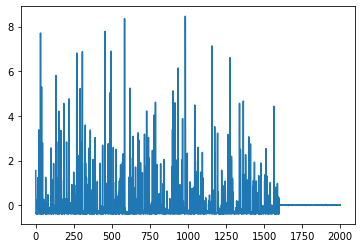

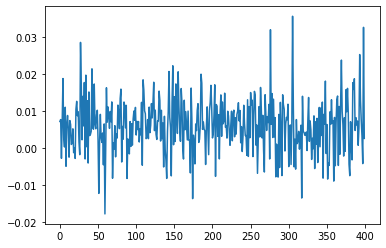

In [65]:
data = {'x':torch.from_numpy(linear_train),'y':torch.from_numpy(train)}
if (use_gpu):
    data['x'],data['y'] = data['x'].cuda(),data['y'].cuda()
for t in range(iterate):
    prediction = net(data['x'])
    loss = loss_func(prediction, data['y'])     # must be (1. nn output, 2. target)
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
print(loss)
if(use_gpu):
    net = net.cpu()
predict = net(torch.from_numpy(linear_test))    
pre = predict.detach().numpy().flatten()
total = np.concatenate([train,pre])
x = range(total.shape[0])
y = total[x]
plt.plot(x,y)
plt.show()
x = range(pre.shape[0])
y = pre[x]
plt.plot(x,y)
plt.show()
np.save(r'prediction/L_'+str(iterate)+'.npy',pre)
# L_500 nMSE=1.0133146432026512	
# L_1000 nMSE=1.0133162861099463		

# 加入一次主成分分析
PCA_50_L_250 nMSE=1.0133798118586848	
PCA_50_L_500 nMSE=1.01336904168864
PCA_75_L_500 nMSE=1.01325851053674	
# PCA_100_L_500 nMSE=1.0130263129723853
PCA_100_L_1000 nMSE=1.0130448413157673	
PCA_150_L_500 nMSE=1.0136613879145158	

In [66]:
#主成分分析
def pca(X,n):
    """
    input:矩阵X,每一行一条训练数据
    return:投影矩阵（按照维度的重要性排序）、方差和均值
    """
    #获取维数
    num_data,dim = X.shape
    print(num_data,dim)

    #数据中心化:因为数据是按行保存的
    mean_X = X.mean(axis=0)
    X = np.subtract(X, mean_X)
    #pca使用SVD方法
    U,S,V = np.linalg.svd(X)
    #返回前n维的数据
    U = U[:,:n]
        
    #返回投影矩阵、方差和均值
    return U

In [67]:
n0 = 100
nL = 1
nH = nL
iterate = 1000
class PCALRnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(n0,nH)
        self.predict = nn.Linear(nH,nL) 
    
    def forward(self,x):
        x = nn.functional.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [68]:
net = PCALRnet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()
if(use_gpu):
    net = net.cuda()
    loss_func = loss_func.cuda()

In [69]:
PCA_tmp = pca(linear_train,n0)
PCA_train = torch.from_numpy(np.array(PCA_tmp,dtype = float)).float()
PCA_tmp =pca(linear_test,n0)
PCA_test = torch.from_numpy(np.array(PCA_tmp,dtype = float)).float()

1600 279
400 279


In [70]:
if (use_gpu):
    PCA_train = PCA_train.cuda()
for t in range(iterate):
    prediction = net(PCA_train)
    loss = loss_func(prediction, data['y'])     # must be (1. nn output, 2. target)
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
print(loss)

tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)


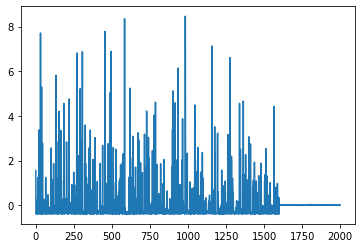

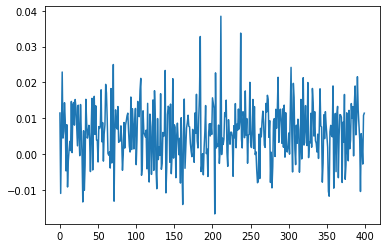

In [71]:
if(use_gpu):
    net = net.cpu()
    PCA_test = PCA_test.cpu()
predict = net(PCA_test)    
pre = predict.detach().numpy().flatten()
total = np.concatenate([train,pre])
x = range(total.shape[0])
y = total[x]
plt.plot(x,y)
plt.show()
x = range(pre.shape[0])
y = pre[x]
plt.plot(x,y)
plt.show()
np.save(r'prediction/PCA_'+str(n0)+'_L_'+str(iterate)+'.npy',pre)

# 尝试非线性回归
